> Ref: Amplitude의 [Product Analytics Playbook: Mastering Retention](https://www.productanalyticsplaybook.com/#top)

위의 내용 中 1. **리텐션 커브** 2. **리텐션 라이프사이클 프레임워크** 에 대한 분석 및 시각화 작업과 이를 파이프라인화 할 수 있는 메소드를 만들어본다.

# 1. 데이터 가공 단계

- 소스가 되는 데이터의 형태는 웹/앱에서 발생하는 이벤트 로그를 가정
- 이벤트 로그를 기반으로 리텐션 분석이 가능한 형태의 테이블 만들기
- 데이터 처리는 pyspark를 통해 진행

In [1]:
import os
os.environ["PYSPARK_PYTHON"] = "/opt/homebrew/bin/python3"

In [2]:
from pyspark.sql import SparkSession, Row, DataFrame
from pyspark import SparkContext

In [3]:
MAX_MEMORY = "32g"
SPARK = (
    SparkSession.builder.appName("Plots Tutorial Shell")
    .config("spark.driver.host", "localhost")
    .config("spark.driver.memory", MAX_MEMORY)
    .config("spark.sql.session.timeZone", "Asia/Seoul")
    .config("spark.driver.extraJavaOptions", "-Duser.timezone=Asia/Seoul")
    .config("spark.executor.extraJavaOptions", "-Duser.timezone=Asia/Seoul")
    .getOrCreate()
)

21/07/14 20:11:56 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [4]:
from abc import ABC, abstractmethod

from pyspark.sql import DataFrame, SparkSession
from pyspark.sql.functions import col
from pyspark.sql.types import StringType, StructField, StructType, TimestampType


class DataMart(ABC):
    schema: StructType

    def __init__(self, spark: SparkSession):
        self.spark = spark

    @abstractmethod
    def df(self, **kwargs) -> DataFrame:
        raise NotImplementedError()

    def fix_schema(self, df: DataFrame) -> DataFrame:
        select_expr_list = []
        for field in self.schema:
            select_expr_list.append(col(field.name).cast(field.dataType))

        return df.select(*select_expr_list)


class EventMart(DataMart):
    event_name: str

    schema = StructType(
        [
            StructField("timestamp", TimestampType()),
            StructField("user_id", StringType()),
            StructField("event_name", StringType()),
        ]
    )

In [5]:
import datetime

In [6]:
# event log samples
class SampleEventMart(EventMart):
    event_name = "chat"

    def df(self, start_date=None, end_date=None):
        df = self.spark.createDataFrame(
            [
                Row(timestamp=datetime.datetime(2021, 7, 1, 1, 1, 1), user_id="3215", event_name="chat"),
                Row(timestamp=datetime.datetime(2021, 7, 1, 1, 1, 1), user_id="1400", event_name="chat"),
                Row(timestamp=datetime.datetime(2021, 7, 1, 1, 1, 1), user_id="1000", event_name="chat"),
                Row(timestamp=datetime.datetime(2021, 7, 1, 1, 1, 1), user_id="800", event_name="chat"),
                Row(timestamp=datetime.datetime(2021, 7, 1, 1, 1, 1), user_id="600", event_name="chat"),
                Row(timestamp=datetime.datetime(2021, 7, 1, 1, 1, 1), user_id="580", event_name="chat"),
                Row(timestamp=datetime.datetime(2021, 7, 1, 1, 1, 1), user_id="582", event_name="chat"),
                Row(timestamp=datetime.datetime(2021, 7, 1, 1, 1, 1), user_id="550", event_name="chat"),
                Row(timestamp=datetime.datetime(2021, 7, 2, 1, 1, 1), user_id="3215", event_name="chat"),
                Row(timestamp=datetime.datetime(2021, 7, 2, 1, 1, 1), user_id="1400", event_name="chat"),
                Row(timestamp=datetime.datetime(2021, 7, 2, 1, 1, 1), user_id="1000", event_name="chat"),
                Row(timestamp=datetime.datetime(2021, 7, 3, 1, 1, 1), user_id="3215", event_name="chat"),
                Row(timestamp=datetime.datetime(2021, 7, 4, 1, 1, 1), user_id="1400", event_name="chat"),
                Row(timestamp=datetime.datetime(2021, 7, 3, 1, 1, 1), user_id="1000", event_name="chat"),
                Row(timestamp=datetime.datetime(2021, 7, 3, 1, 1, 1), user_id="800", event_name="chat"),
                Row(timestamp=datetime.datetime(2021, 7, 3, 1, 1, 1), user_id="600", event_name="chat"),
                Row(timestamp=datetime.datetime(2021, 7, 4, 1, 1, 1), user_id="580", event_name="chat"),
                Row(timestamp=datetime.datetime(2021, 7, 5, 1, 1, 1), user_id="582", event_name="chat"),
                Row(timestamp=datetime.datetime(2021, 7, 6, 1, 1, 1), user_id="550", event_name="chat"),
            ]
        )

        return self.fix_schema(df=df)

sample_event_mart = SampleEventMart(spark=SPARK)

## TASK1: 특정 이벤트 발생을 기준으로 유저 리텐션 측정

In [7]:
import datetime
from collections import defaultdict
from math import floor
from typing import Dict, Iterable, List, Literal, Optional, Union

from pyspark.sql import DataFrame, Row, SparkSession
from pyspark.sql import Window as W
from pyspark.sql import functions as F
from pyspark.sql import types as T

Retention 측정 방법 세 가지
1. N-Day
2. Bracket
3. Unbounded

In [8]:
RetentionType = Union[Literal["N-Day"], Literal["Bracket"], Literal["Unbounded"]]

In [9]:
class RetentionMart(DataMart):
    template_fields = [
        T.StructField("event_name", T.StringType()),
        T.StructField("retention_type", T.StringType()),
        T.StructField("period_index", T.IntegerType()),
        T.StructField(
            "date_period",
            T.StructType(
                [
                    T.StructField("from", T.DateType()),
                    T.StructField("to", T.DateType()),
                ]
            ),
        ),
    ]

    schema = T.StructType(
        [
            *template_fields,
            T.StructField("num_users", T.IntegerType()),
            T.StructField("retention_rate", T.FloatType()),
        ]
    )

    def __init__(self, spark: SparkSession, type: RetentionType):
        self.spark = spark
        self.type = type

    def nday(
        self,
        event_df: DataFrame,
        event_name: str,
        start_date: datetime.date,
        end_date: datetime.date,
    ) -> DataFrame:
        window_size = (end_date - start_date).days + 1
        template = self.spark.createDataFrame(
            [
                Row(
                    event_name=event_name,
                    retention_type=self.type,
                    period_index=i,
                    date_period={
                        "from": start_date + datetime.timedelta(days=i),
                        "to": start_date + datetime.timedelta(days=i),
                    },
                )
                for i in range(window_size)
            ],
            schema=T.StructType(self.template_fields),
        )

        df_with_date = event_df.withColumn(
            "date", F.col("timestamp").cast(T.DateType())
        )

        cohort_members = list(
            set(
                row.user_id
                for row in df_with_date.filter(F.col("date") == start_date)
                .select("user_id")
                .collect()
            )
        )

        df_filtered = df_with_date.filter(
            (F.col("date") >= start_date) & (F.col("date") <= end_date)
        ).filter(F.col("user_id").isin(cohort_members))

        df_grouped = (
            df_filtered.groupBy("date")
            .agg(F.size(F.collect_set("user_id")).alias("num_users"))
            .withColumn(
                "period_index",
                F.row_number().over(W.orderBy("date")) - 1,
            )
        )

        retention_df = (
            template.join(
                df_grouped.select("period_index", "num_users"),
                on=["period_index"],
                how="left",
            )
            .fillna(subset=["num_users"], value=0)
            .withColumn("retention_rate", F.col("num_users") / len(cohort_members))
            .orderBy("period_index")
        )

        return retention_df

    def get_date_brackets(
        self,
        start_date: datetime.date,
        end_date: datetime.date,
        bracket_sizes: List[int],
    ) -> List[Dict[str, datetime.date]]:
        idx = 0
        lower = start_date
        upper = min(
            [start_date + datetime.timedelta(days=bracket_sizes[idx] - 1), end_date]
        )
        brackets = [{"from": lower, "to": upper}]
        while idx + 1 < len(bracket_sizes) and upper < end_date:
            idx += 1
            lower = upper + datetime.timedelta(days=1)
            upper = min([upper + datetime.timedelta(days=bracket_sizes[idx]), end_date])
            brackets.append({"from": lower, "to": upper})

        return brackets

    def bracket(
        self,
        event_df: DataFrame,
        event_name: str,
        start_date: datetime.date,
        end_date: datetime.date,
        bracket_size: Optional[int],
        custom_bracket_sizes: Optional[List[int]],
    ) -> DataFrame:
        if custom_bracket_sizes:
            _brackets = self.get_date_brackets(
                start_date=start_date,
                end_date=end_date,
                bracket_sizes=custom_bracket_sizes,
            )
        elif bracket_size:
            window_size = (end_date - start_date).days + 1
            bracket_sizes = [bracket_size] * floor(window_size / bracket_size)
            bracket_sizes += [window_size - sum(bracket_sizes)]
            _brackets = self.get_date_brackets(
                start_date=start_date,
                end_date=end_date,
                bracket_sizes=bracket_sizes,
            )
        else:
            raise TypeError("bracket_size or custom_brack_sizes needed")

        template = self.spark.createDataFrame(
            [
                Row(
                    event_name=event_name,
                    retention_type=self.type,
                    period_index=idx,
                    date_period=bracket,
                )
                for idx, bracket in enumerate(_brackets)
            ],
            schema=T.StructType(self.template_fields),
        )

        df_with_date = event_df.withColumn(
            "date", F.col("timestamp").cast(T.DateType())
        )

        cohort_members = list(
            set(
                row.user_id
                for row in (
                    df_with_date.filter(
                        (F.col("date") >= _brackets[0]["from"])
                        & (F.col("date") <= _brackets[0]["to"])
                    )
                    .select("user_id")
                    .collect()
                )
            )
        )

        df_filtered = df_with_date.filter(
            (F.col("date") >= start_date) & (F.col("date") <= end_date)
        ).filter(F.col("user_id").isin(cohort_members))

        @F.udf(T.IntegerType())
        def bracket_mapper(date: datetime.date):
            for idx, bracket in enumerate(_brackets):
                if date >= bracket["from"] and date <= bracket["to"]:
                    return idx

        df_grouped = (
            df_filtered.withColumn("period_index", bracket_mapper(F.col("date")))
            .groupBy("period_index")
            .agg(F.size(F.collect_set("user_id")).alias("num_users"))
        )

        retention_df = (
            template.join(
                df_grouped.select("period_index", "num_users"),
                on=["period_index"],
                how="left",
            )
            .fillna(subset=["num_users"], value=0)
            .withColumn("retention_rate", F.col("num_users") / len(cohort_members))
            .orderBy("period_index")
        )

        return retention_df

    def unbounded(
        self,
        event_df: DataFrame,
        event_name: str,
        start_date: datetime.date,
        end_date: datetime.date,
    ) -> DataFrame:
        window_size = (end_date - start_date).days + 1
        template = self.spark.createDataFrame(
            [
                Row(
                    event_name=event_name,
                    retention_type=self.type,
                    period_index=i,
                    date_period={
                        "from": start_date + datetime.timedelta(days=i),
                        "to": start_date + datetime.timedelta(days=i),
                    },
                )
                for i in range(window_size)
            ],
            schema=T.StructType(self.template_fields),
        )

        df_with_date = event_df.withColumn(
            "date", F.col("timestamp").cast(T.DateType())
        )

        cohort_members = list(
            set(
                row.user_id
                for row in df_with_date.filter(F.col("date") == start_date)
                .select("user_id")
                .collect()
            )
        )

        df_filtered = df_with_date.filter(
            (F.col("date") >= start_date) & (F.col("date") <= end_date)
        ).filter(F.col("user_id").isin(cohort_members))

        df_grouped = (
            df_filtered.withColumn(
                "num_users",
                F.size(
                    F.collect_set("user_id").over(
                        W.orderBy("date").rowsBetween(
                            W.currentRow, W.unboundedFollowing
                        )
                    )
                ),
            )
            .dropDuplicates(["date"])
            .withColumn(
                "period_index",
                F.row_number().over(W.orderBy("date")) - 1,
            )
        )

        retention_df = (
            template.join(
                df_grouped.select("period_index", "num_users"),
                on=["period_index"],
                how="left",
            )
            .fillna(subset=["num_users"], value=0)
            .withColumn("retention_rate", F.col("num_users") / len(cohort_members))
            .orderBy("period_index")
        )

        return retention_df

    def df(
        self,
        event_mart: EventMart,
        start_date: datetime.date,
        end_date: datetime.date,
        bracket_size: Optional[int] = None,
        custom_bracket_sizes: Optional[List[int]] = None,
    ) -> DataFrame:
        if self.type == "N-Day":
            retention_df = self.nday(
                event_df=event_mart.df(
                    start_date=start_date - datetime.timedelta(days=365),
                    end_date=end_date,
                ),
                event_name=event_mart.event_name,
                start_date=start_date,
                end_date=end_date,
            )
        elif self.type == "Bracket":
            retention_df = self.bracket(
                event_df=event_mart.df(
                    start_date=start_date - datetime.timedelta(days=365),
                    end_date=end_date,
                ),
                event_name=event_mart.event_name,
                start_date=start_date,
                end_date=end_date,
                bracket_size=bracket_size,
                custom_bracket_sizes=custom_bracket_sizes,
            )
        elif self.type == "Unbounded":
            retention_df = self.unbounded(
                event_df=event_mart.df(
                    start_date=start_date - datetime.timedelta(days=365),
                    end_date=end_date,
                ),
                event_name=event_mart.event_name,
                start_date=start_date,
                end_date=end_date,
            )
        else:
            raise TypeError("Retention type undefined")

        return self.fix_schema(df=retention_df)

### N-day 방식 샘플

In [10]:
retention_mart = RetentionMart(spark=SPARK, type="N-Day")

In [11]:
retention_df = retention_mart.df(
    event_mart=sample_event_mart, 
    start_date=datetime.date(2021, 7, 1), 
    end_date=datetime.date(2021, 7, 6)
)

In [12]:
retention_df.show(20, False)

21/07/14 20:12:06 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


+----------+--------------+------------+------------------------+---------+--------------+
|event_name|retention_type|period_index|date_period             |num_users|retention_rate|
+----------+--------------+------------+------------------------+---------+--------------+
|chat      |N-Day         |0           |{2021-07-01, 2021-07-01}|8        |1.0           |
|chat      |N-Day         |1           |{2021-07-02, 2021-07-02}|3        |0.375         |
|chat      |N-Day         |2           |{2021-07-03, 2021-07-03}|4        |0.5           |
|chat      |N-Day         |3           |{2021-07-04, 2021-07-04}|2        |0.25          |
|chat      |N-Day         |4           |{2021-07-05, 2021-07-05}|1        |0.125         |
|chat      |N-Day         |5           |{2021-07-06, 2021-07-06}|1        |0.125         |
+----------+--------------+------------+------------------------+---------+--------------+



### Bracket 방식 샘플

In [13]:
retention_mart = RetentionMart(spark=SPARK, type="Bracket")

In [14]:
retention_df = retention_mart.df(
    event_mart=sample_event_mart, 
    start_date=datetime.date(2021, 7, 1), 
    end_date=datetime.date(2021, 7, 6),
    bracket_size=2
)

In [15]:
retention_df.show(20, False)

+----------+--------------+------------+------------------------+---------+--------------+
|event_name|retention_type|period_index|date_period             |num_users|retention_rate|
+----------+--------------+------------+------------------------+---------+--------------+
|chat      |Bracket       |0           |{2021-07-01, 2021-07-02}|8        |1.0           |
|chat      |Bracket       |1           |{2021-07-03, 2021-07-04}|6        |0.75          |
|chat      |Bracket       |2           |{2021-07-05, 2021-07-06}|2        |0.25          |
+----------+--------------+------------+------------------------+---------+--------------+



### Unbounded 방식 샘플

In [16]:
retention_mart = RetentionMart(spark=SPARK, type="Unbounded")

In [17]:
retention_df = retention_mart.df(
    event_mart=sample_event_mart, 
    start_date=datetime.date(2021, 7, 1), 
    end_date=datetime.date(2021, 7, 6),
)

In [18]:
retention_df.show(20, False)

21/07/14 20:12:19 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
21/07/14 20:12:19 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


+----------+--------------+------------+------------------------+---------+--------------+
|event_name|retention_type|period_index|date_period             |num_users|retention_rate|
+----------+--------------+------------+------------------------+---------+--------------+
|chat      |Unbounded     |0           |{2021-07-01, 2021-07-01}|8        |1.0           |
|chat      |Unbounded     |1           |{2021-07-02, 2021-07-02}|8        |1.0           |
|chat      |Unbounded     |2           |{2021-07-03, 2021-07-03}|8        |1.0           |
|chat      |Unbounded     |3           |{2021-07-04, 2021-07-04}|4        |0.5           |
|chat      |Unbounded     |4           |{2021-07-05, 2021-07-05}|2        |0.25          |
|chat      |Unbounded     |5           |{2021-07-06, 2021-07-06}|1        |0.125         |
+----------+--------------+------------+------------------------+---------+--------------+



## TASK2: 리텐션 라이프사이클에 따른 유저 그룹 분류

1. New Users
2. Current Users(+Power Users)
3. Resurrected Users
4. Dormant Users

유저 그룹 분류를 위해서는 이벤트 유형에 따른 유저의 리텐션 주기를 미리 파악하고 있어야 함

*chat 이벤트의 주기는 하루(daily)로 가정*

In [19]:
class UserGroupMart(DataMart):
    schema = T.StructType(
        [
            T.StructField("event_name", T.StringType()),
            T.StructField("date", T.DateType()),
            T.StructField("new_users", T.IntegerType()),
            T.StructField("current_users", T.IntegerType()),
            T.StructField("resurrected_users", T.IntegerType()),
            T.StructField("dormant_users", T.IntegerType()),
        ]
    )

    def get_intervals(
        self,
        today: datetime.date,
        retention_cycle: int,
    ) -> Iterable[List[datetime.date]]:
        current_interval = []
        for i in range(retention_cycle):
            current_interval.append(today - datetime.timedelta(days=i))
        current_interval.sort()

        previous_interval = []
        for j in range(retention_cycle, retention_cycle * 2):
            previous_interval.append(today - datetime.timedelta(days=j))
        previous_interval.sort()

        return previous_interval, current_interval

    def df(
        self,
        event_mart: EventMart,
        cycle_days: int,
        start_date: datetime.date,
        end_date: datetime.date,
    ) -> DataFrame:
        df_grouped = (
            event_mart.df(
                start_date=start_date - datetime.timedelta(days=365),
                end_date=end_date,
            )
            .withColumn(
                "new_user_flag",
                F.when(
                    F.min("timestamp").over(W.partitionBy("user_id"))
                    == F.col("timestamp"),
                    F.col("user_id"),
                ).otherwise(F.lit(None)),
            )
            .withColumn("date", F.col("timestamp").cast(T.DateType()))
            .filter((F.col("date") >= start_date) & (F.col("date") <= end_date))
            .withColumn(
                "all_users_so_far",
                F.collect_set("user_id").over(
                    W.orderBy("timestamp").rowsBetween(
                        W.unboundedPreceding, W.currentRow
                    )
                ),
            )
            .orderBy("timestamp")
            .groupBy("event_name", "date")
            .agg(
                F.collect_set("user_id").alias("active_users"),
                F.collect_set("new_user_flag").alias("new_users"),
                F.last("all_users_so_far").alias("user_pool"),
            )
        )

        daily_user_groups = {
            row.date: {
                "active_users": row.active_users,
                "new_users": row.new_users,
                "user_pool": row.user_pool,
            }
            for row in df_grouped.collect()
        }

        date_range = [
            start_date + datetime.timedelta(days=i)
            for i in range((end_date - start_date).days + 1)
        ]
        user_segmentations = defaultdict(dict)
        for date in date_range:
            previous_interval, current_interval = self.get_intervals(
                today=date, retention_cycle=cycle_days
            )

            # 1. New Users & Active Users
            new_users = set()
            active_users = set()
            for _date in set(current_interval) & set(date_range):
                new_users |= set(daily_user_groups[_date]["new_users"])
                active_users |= set(daily_user_groups[_date]["active_users"])

            user_segmentations[date]["new_users"] = new_users

            # 2. Current Users
            was_active_users = set()
            for _date in set(previous_interval) & set(date_range):
                if _date not in date_range:
                    continue
                was_active_users |= set(daily_user_groups[_date]["active_users"])

            user_segmentations[date]["current_users"] = active_users & was_active_users

            # 3. Resurrected Users
            user_segmentations[date]["resurrected_users"] = (
                active_users - was_active_users - new_users
            )

            # 4. Dormant Users
            user_pool_so_far = set(daily_user_groups[date]["user_pool"])

            user_segmentations[date]["dormant_users"] = user_pool_so_far - active_users

        user_group_df = self.spark.createDataFrame(
            [
                Row(
                    event_name=event_mart.event_name,
                    date=date,
                    new_users=len(user_groups["new_users"]),
                    current_users=len(user_groups["current_users"]),
                    resurrected_users=len(user_groups["resurrected_users"]),
                    dormant_users=len(user_groups["dormant_users"]),
                )
                for date, user_groups in user_segmentations.items()
            ]
        )

        return self.fix_schema(df=user_group_df)

### 유저 그룹 분류 샘플

In [20]:
user_group_mart = UserGroupMart(spark=SPARK)

In [21]:
user_group_df = user_group_mart.df(
    event_mart=sample_event_mart,
    cycle_days=1,
    start_date=datetime.date(2021, 7, 1),
    end_date=datetime.date(2021, 7, 6)
)

21/07/14 20:12:23 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


In [22]:
user_group_df.show()

+----------+----------+---------+-------------+-----------------+-------------+
|event_name|      date|new_users|current_users|resurrected_users|dormant_users|
+----------+----------+---------+-------------+-----------------+-------------+
|      chat|2021-07-01|        8|            0|                0|            0|
|      chat|2021-07-02|        0|            3|                0|            5|
|      chat|2021-07-03|        0|            2|                2|            4|
|      chat|2021-07-04|        0|            0|                2|            6|
|      chat|2021-07-05|        0|            0|                1|            7|
|      chat|2021-07-06|        0|            0|                1|            7|
+----------+----------+---------+-------------+-----------------+-------------+



# 2. 시각화 단계

- seaborn 사용해서 기본 테마 잡고
- color 직접 지정해서 plot 커스텀할 수 있는 시각화 메소드 구현

In [23]:
from abc import ABC, abstractmethod
from typing import Iterable, List, Optional, Tuple, Union

import numpy as np
from matplotlib import pyplot as plt
from pyspark.sql import DataFrame

from IPython.display import display

In [24]:
Numeric = Union[int, float]


class Visualizer(ABC):
    def __init__(
        self,
        style: str,
        figsize: Tuple[Numeric, Numeric],
        facecolor: str = "w",
        **kwargs,
    ):
        plt.style.use(style)
        self.fig = self.create_figure(figsize=figsize, facecolor=facecolor, **kwargs)

    @abstractmethod
    def plot(self, df: DataFrame, **kwargs) -> plt.Figure:
        raise NotImplementedError

    def create_figure(
        self,
        figsize: Tuple[Numeric, Numeric],
        facecolor: str,
        **kwargs,
    ) -> plt.Figure:
        return plt.figure(figsize=figsize, facecolor=facecolor, **kwargs)

    def create_axes(
        self,
        facecolor: str,
        **kwargs,
    ) -> Union[plt.Axes, Iterable[plt.Axes]]:
        return self.fig.subplots(subplot_kw=dict(facecolor=facecolor), **kwargs)

    def lineplot(
        self,
        ax: plt.Axes,
        linecolor: str,
        linestyle: str,
        markerstyle: str,
        markersize: Numeric,
        markercolor: str,
        x_data: List[Numeric],
        y_data: List[Numeric],
        y_data_label: str = None,
    ):
        if y_data_label is not None:
            ax.plot(
                x_data,
                y_data,
                color=linecolor,
                ls=linestyle,
                marker=markerstyle,
                ms=markersize,
                mfc=markercolor,
                label=y_data_label,
            )
        else:
            ax.plot(
                x_data,
                y_data,
                color=linecolor,
                ls=linestyle,
                marker=markerstyle,
                ms=markersize,
                mfc=markercolor,
            )

    def barplot(
        self,
        ax: plt.Axes,
        barcolor: str,
        barwidth: Numeric,
        edgecolor: str,
        linewidth: Numeric,
        x_data: List[Numeric],
        y_data: List[Numeric],
        y_data_label: str = None,
    ):
        if y_data_label is not None:
            ax.bar(
                x=x_data,
                height=y_data,
                color=barcolor,
                width=barwidth,
                edgecolor=edgecolor,
                linewidth=linewidth,
                label=y_data_label,
            )
        else:
            ax.bar(
                x=x_data,
                height=y_data,
                color=barcolor,
                width=barwidth,
                edgecolor=edgecolor,
                linewidth=linewidth,
            )

    def stacked_barplot(
        self,
        ax: plt.Axes,
        barcolor_list: List[str],
        barwidth: Numeric,
        edgecolor: str,
        linewidth: Numeric,
        x_data: List[Numeric],
        y_data_list: List[List[Numeric]],
        y_data_label_list: List[str],
    ):
        # First Bar
        first_y_data = y_data_list.pop(0)
        first_y_label = y_data_label_list.pop(0)
        first_barcolor = barcolor_list.pop(0)
        ax.bar(
            x=x_data,
            height=first_y_data,
            color=first_barcolor,
            width=barwidth,
            label=first_y_label,
            edgecolor=edgecolor,
            linewidth=linewidth,
        )
        bottoms = np.array(first_y_data)
        for y_data, y_label, barcolor in zip(
            y_data_list, y_data_label_list, barcolor_list
        ):
            ax.bar(
                x=x_data,
                height=y_data,
                color=barcolor,
                width=barwidth,
                bottom=bottoms,
                label=y_label,
                edgecolor=edgecolor,
                linewidth=linewidth,
            )
            bottoms += np.array(y_data)

    def xaxis_settings(
        self,
        ax: plt.Axes,
        xaxis_label: Optional[str],
        xticks: List[Numeric],
        xtick_labels: List[str],
        fontsize: Numeric,
        fontcolor: str,
        rotation: Numeric = None,
    ):
        # Set xaxis label
        ax.set_xlabel(xaxis_label, fontsize=fontsize, color=fontcolor)

        # Set x tick
        ax.set_xticks(xticks)

        # Set x tick labels
        if rotation:
            ax.set_xticklabels(
                xtick_labels,
                fontsize=fontsize,
                color=fontcolor,
                rotation=rotation,
            )
        else:
            ax.set_xticklabels(xtick_labels, fontsize=fontsize, color=fontcolor)

    def yaxis_settings(
        self,
        ax: plt.Axes,
        yaxis_label: Optional[str],
        yticks: List[Numeric],
        ytick_labels: List[str],
        fontsize: Numeric,
        fontcolor: str,
        rotation: Numeric = None,
    ):
        # Set xaxis label
        ax.set_ylabel(yaxis_label, fontsize=fontsize, color=fontcolor)

        # Set x tick
        ax.set_yticks(yticks)

        # Set x tick labels
        if rotation:
            ax.set_yticklabels(
                ytick_labels,
                fontsize=fontsize,
                color=fontcolor,
                rotation=rotation,
            )
        else:
            ax.set_yticklabels(ytick_labels, fontsize=fontsize, color=fontcolor)

    def annotate(
        self,
        ax: plt.Axes,
        x_coordinates: List[Numeric],
        y_coordinates: List[Numeric],
        annotates: List[str],
        size: Numeric,
        color: str,
    ):
        for x, y, t in zip(x_coordinates, y_coordinates, annotates):
            ax.text(x, y, t, size=size, color=color)

## TASK1: 리텐션 커브 &rarr; Line Plot

In [25]:
class RetentionCurveVisualizer(Visualizer):
    def plot(
        self,
        df: DataFrame,
        facecolor: str,
        linecolor: str,
        linestyle: str,
        markercolor: str,
        markerstyle: str,
        markersize: Union[int, float],
        fontcolor: str,
        fontsize: Union[int, float],
        gridcolor: str,
        title: str,
    ):
        data = (
            df.orderBy("period_index")
            .select("period_index", "date_period", "retention_rate", "num_users")
            .collect()
        )
        retention_type = df.select("retention_type").first().retention_type

        # x & y data
        x_data = [row.period_index for row in data]
        y_data = [row.retention_rate for row in data]

        # y ticks
        yticks = np.arange(0, 1.01, 0.1)

        # x & y tick labels
        if retention_type == "Bracket":
            xtick_labels = [
                "~".join(
                    [
                        f"Period {idx}\n{row.date_period['from'].month}/{row.date_period['from'].day}",
                        f"{row.date_period['to'].month}/{row.date_period['to'].day}",
                    ]
                )
                for idx, row in enumerate(data)
            ]
        else:
            xtick_labels = [
                f"Day {idx}\n{row.date_period['from'].month}/{row.date_period['from'].day}"
                for idx, row in enumerate(data)
            ]
        ytick_labels = ["{:.0%}".format(rate) for rate in yticks]

        # annotates
        annotates = [f"{row.num_users} Users" for row in data]

        # create Axes
        ax = self.create_axes(facecolor=facecolor)

        # line plot
        self.lineplot(
            ax=ax,
            linecolor=linecolor,
            linestyle=linestyle,
            markerstyle=markerstyle,
            markersize=markersize,
            markercolor=markercolor,
            x_data=x_data,
            y_data=y_data,
        )

        # set title
        assert not isinstance(ax, Iterable)
        ax.set_title(title, size=fontsize, color=fontcolor)

        # set x tick & label
        if retention_type == "Bracket":
            self.xaxis_settings(
                ax=ax,
                xaxis_label=None,
                xticks=x_data,
                xtick_labels=xtick_labels,
                fontsize=fontsize,
                fontcolor=fontcolor,
                rotation=20,
            )
        else:
            self.xaxis_settings(
                ax=ax,
                xaxis_label=None,
                xticks=x_data,
                xtick_labels=xtick_labels,
                fontsize=fontsize,
                fontcolor=fontcolor,
            )

        # set y tick & label
        self.yaxis_settings(
            ax=ax,
            yaxis_label=None,
            yticks=yticks,
            ytick_labels=ytick_labels,
            fontsize=fontsize,
            fontcolor=fontcolor,
        )

        # Annotate
        self.annotate(
            ax=ax,
            x_coordinates=[x - 0.1 for x in x_data],
            y_coordinates=[y + 0.025 for y in y_data],
            annotates=annotates,
            size=fontsize,
            color=fontcolor,
        )

        # Set grid
        ax.grid(True, axis="both", color=gridcolor)

In [26]:
viz = RetentionCurveVisualizer(figsize=(10, 8), style="seaborn-darkgrid")

<Figure size 720x576 with 0 Axes>

In [27]:
facecolor = "w"
linecolor = "#002999"
linestyle = ":"
markercolor = linecolor
markerstyle = "s"
markersize = 7
fontcolor = "#002999"
fontsize = 12
gridcolor = "#eaeaf2"
title = "Retention Curve"

In [28]:
viz.plot(
    df=retention_df,
    facecolor=facecolor,
    linecolor=linecolor,
    linestyle=linestyle,
    markercolor=markercolor,
    markerstyle=markerstyle,
    markersize=markersize,
    fontcolor=fontcolor,
    fontsize=fontsize,
    gridcolor=gridcolor,
    title=title,
)

21/07/14 20:12:27 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
21/07/14 20:12:27 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
21/07/14 20:12:32 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


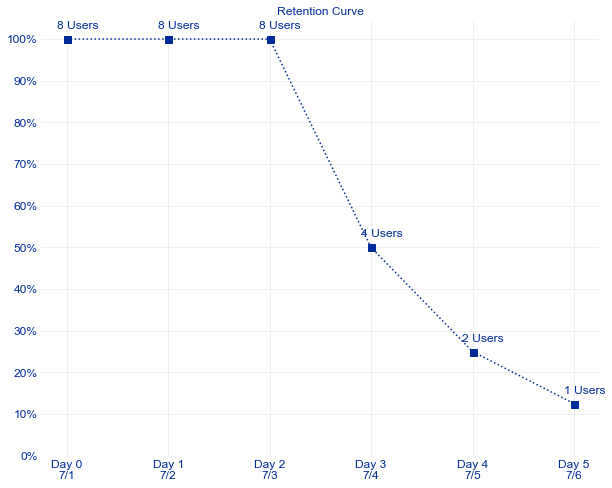

In [29]:
display(viz.fig)

## TASK2: 리텐션 라이프사이클에 따른 User Group 분포 &rarr; Stacked Bar Plot

In [30]:
class UserGroupVisualizer(Visualizer):
    def get_tick_size(self, max_user_count: int):
        digits = len(str(max_user_count))

        if digits == 1:
            return 1
        else:
            big_size = 10 ** digits
            small_size = 10 ** (digits - 1) * 5
            if max_user_count > big_size * 5:
                return big_size
            else:
                return small_size

    def plot(
        self,
        df: DataFrame,
        facecolor: str,
        barcolor_dict: Dict[str, str],
        barwidth: Union[int, float],
        edgecolor: str,
        fontcolor: str,
        fontsize: Union[int, float],
        gridcolor: str,
        title: str,
    ):
        data = df.orderBy("date").collect()
        # x & y data
        x_data = [row.date for row in data]

        y_current_users = [row.current_users for row in data]
        y_resurrected_users = [row.resurrected_users for row in data]
        y_new_users = [row.new_users for row in data]
        y_dormant_users = [-row.dormant_users for row in data]

        # y ticks
        y_max = np.max(
            sum(map(np.array, [y_current_users, y_resurrected_users, y_new_users]))
        )
        y_min = min(y_dormant_users)
        yticks_positive = np.arange(
            0, y_max + 1, self.get_tick_size(max_user_count=y_max)
        )
        yticks_negative = -np.arange(
            0, abs(y_min) + 1, self.get_tick_size(max_user_count=abs(y_min))
        )
        yticks_negative = np.delete(yticks_negative, np.where(yticks_negative == 0))
        yticks_negative.sort()

        yticks = np.concatenate((yticks_negative, yticks_positive))

        # x & y tick lables
        xtick_labels = [f"{date.month}/{date.day}" for date in x_data]
        ytick_labels = np.concatenate((-yticks_negative, yticks_positive))

        # create Axes
        ax = self.create_axes(facecolor=facecolor)

        # 1. Current/Resurrected/New Users -> stacked bar plot
        self.stacked_barplot(
            ax=ax,
            barcolor_list=[
                barcolor_dict["Resurrected Users"],
                barcolor_dict["Current Users"],
                barcolor_dict["New Users"],
            ],
            barwidth=barwidth,
            edgecolor=edgecolor,
            linewidth=1.2,
            x_data=x_data,
            y_data_list=[y_resurrected_users, y_current_users, y_new_users],
            y_data_label_list=["Resurrected Users", "Current Users", "New Users"],
        )

        # 2. Dormant Users -> negative bar plot
        self.barplot(
            ax=ax,
            barcolor=barcolor_dict["Dormant Users"],
            barwidth=barwidth,
            x_data=x_data,
            edgecolor=edgecolor,
            linewidth=1.2,
            y_data=y_dormant_users,
            y_data_label="Dormant Users",
        )

        # set title
        assert not isinstance(ax, Iterable)
        ax.set_title(title, size=fontsize, color=fontcolor)

        # set x tick & label
        self.xaxis_settings(
            ax=ax,
            xaxis_label=None,
            xticks=x_data,
            xtick_labels=xtick_labels,
            fontsize=fontsize,
            fontcolor=fontcolor,
        )

        # set y tick & label
        self.yaxis_settings(
            ax=ax,
            yaxis_label=None,
            yticks=yticks,
            ytick_labels=ytick_labels,
            fontsize=fontsize,
            fontcolor=fontcolor,
        )

        # turn on legend
        ax.legend(labelcolor=fontcolor)

        # turn off x grid and turn on y grid
        ax.grid(False, axis="x")
        ax.grid(True, axis="y", color=gridcolor)

In [38]:
viz = UserGroupVisualizer(figsize=(10, 8), style="seaborn-darkgrid")

<Figure size 720x576 with 0 Axes>

In [39]:
facecolor = "w"
barcolor_dict = {
    "Current Users": "#3269ff",
    "Resurrected Users": "#0036cc",
    "New Users": "#99b4ff",
    "Dormant Users": "#7a8bb8"
}
barwidth = 0.4
fontcolor = "#002999"
fontsize = 12
title = "User Distrubution over Retention Lifecycle"
gridcolor = "#eaeaf2"

In [40]:
viz.plot(
    df=user_group_df,
    facecolor=facecolor,
    barcolor_dict=barcolor_dict,
    barwidth=barwidth,
    edgecolor="w",
    fontcolor=fontcolor,
    fontsize=fontsize,
    gridcolor=gridcolor,
    title=title,
)

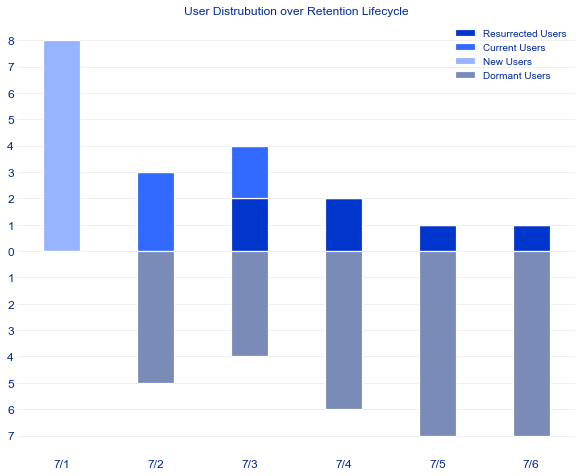

21/07/14 20:20:38 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 285334 ms exceeds timeout 120000 ms
21/07/14 20:20:38 WARN SparkContext: Killing executors is not supported by current scheduler.


In [41]:
display(viz.fig)